'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


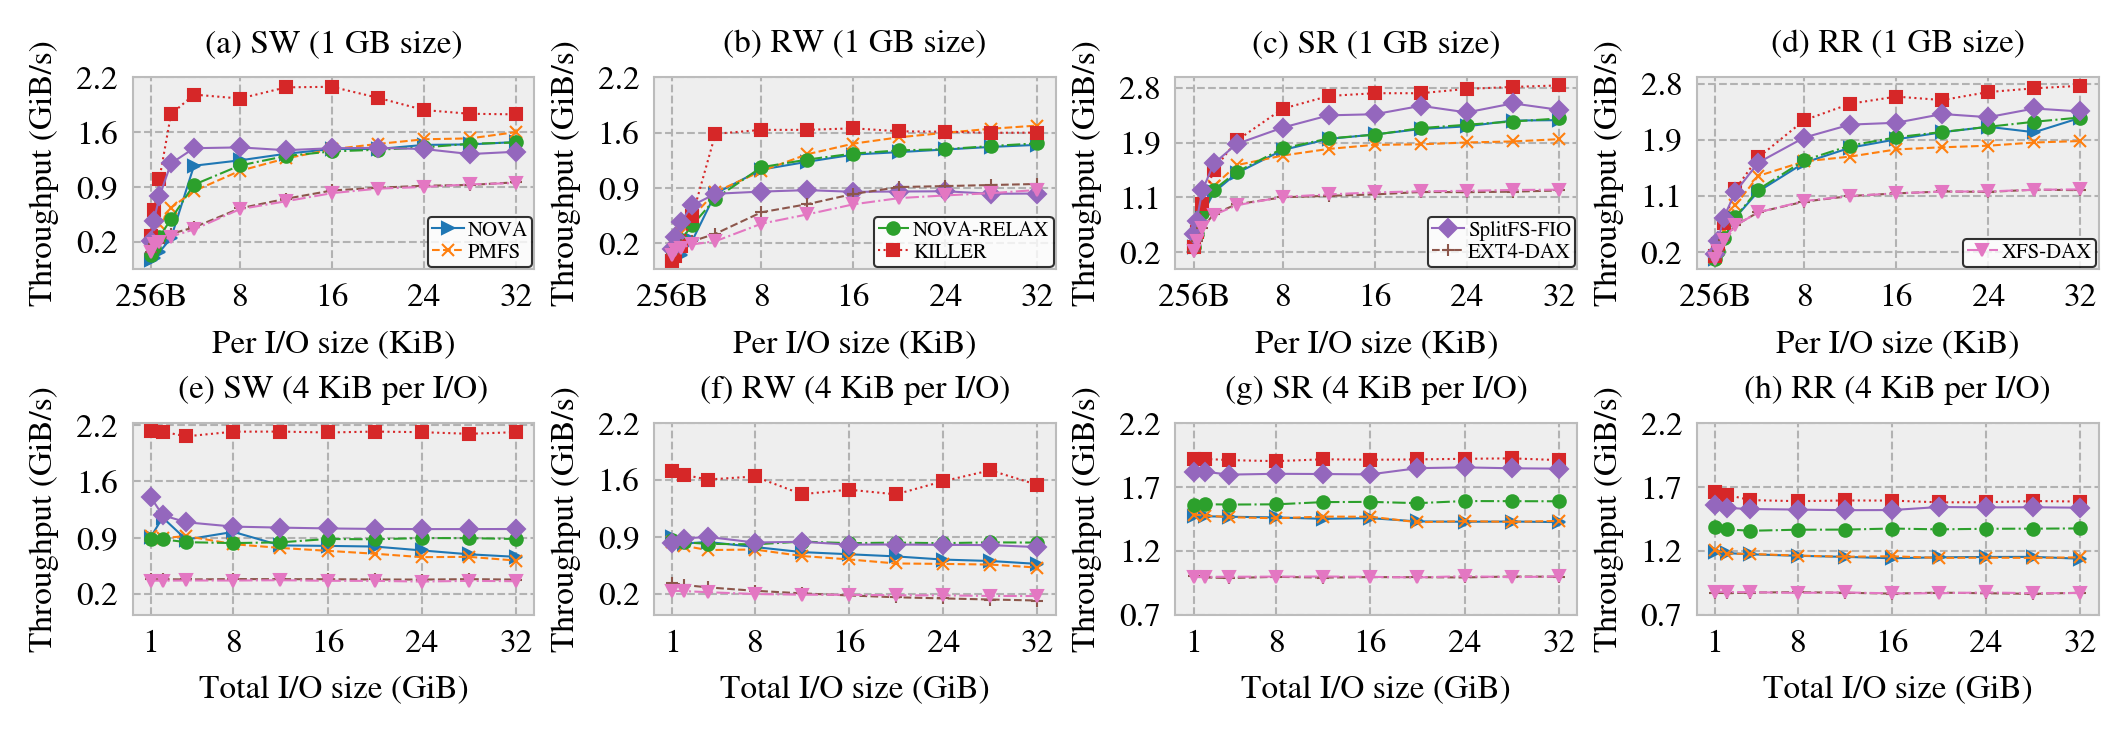

In [4]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('bmh')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("../FIG-ST-MICRO/performance-comparison-table-bsize", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(6)))

line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-."]
subtitles = ["(a) SW (1 GB size)", "(b) RW (1 GB size)", "(c) SR (1 GB size)", "(d) RR (1 GB size)"]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["seq-write", "rnd-write", "seq-read", "rnd-read"]
# bsize = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
bsize =[256, 512, 1024, 2048, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768]

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.5 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(ylim0, ylim1)

# gs0 = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.6)
lines = []
cmap = "tab10"

for op_idx, op in enumerate(ops):
    subfig = plt.subplot(2, 4, op_idx + 1)
    for idx, fs in enumerate(fss):
        if fs == "PMM":
            continue
        line, = plt.plot(bsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), markerfacecolor=plt.get_cmap(cmap)(idx), linewidth=line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx])
        
        lines.append(line)
    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    selected_bsize = bsize
    plt.xticks([256, 8192, 16384, 24576, 32768], labels=[ "256B", 8, 16, 24, 32], fontsize=8)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    # subfig.text(0.5, -0.3, "Threads (#.)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)
    plt.xlabel("Per I/O size (KiB)", fontsize=8) 
    plt.title(subtitles[op_idx], fontsize=8, loc='center')
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
    plt.ylabel('Throughput (GiB/s)', fontsize=8)
    # if (op_idx == 0 or op_idx == 2):
    if op_idx == 0 or op_idx == 1:
        plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)
    else:
        plt.yticks(np.linspace(0.25, 2.75, 4), fontsize=8)

steps = [2, 2, 2, 2]
for ax_id, ax in enumerate(fig.axes):
    start = sum(steps[:ax_id])
    end = start + steps[ax_id]

    leg = ax.legend(lines[start : end], fss[start : end], loc='lower right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, ncol=1, fontsize=5, frameon=True, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5, labelspacing=0.1, borderpad=0.2)
    
    frame = leg.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')

fss.replace("SplitFS-FIO", "SplitFS", inplace=True)

# FSIZE .....................................................................
with open("../FIG-ST-MICRO/performance-comparison-table-fsize", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings

subtitles = ["(e) SW (4 KiB per I/O)", "(f) RW (4 KiB per I/O)", "(g) SR (4 KiB per I/O)", "(h) RR (4 KiB per I/O)"]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["seq-write", "rnd-write", "seq-read", "rnd-read"]
fsize = [1024, 2048, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768]


for op_idx, op in enumerate(ops):
    subfig = plt.subplot(2, 4, op_idx + 1 + 4)
    # subfig = plt.subplot(gs0[op_idx])
    for idx, fs in enumerate(fss):
        if fs == "PMM":
            continue
        line, = plt.plot(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), markerfacecolor=plt.get_cmap(cmap)(idx), linewidth=line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx])
        
            
        # plt.scatter(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), s=0.1)
        lines.append(line)
    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    plt.xticks([1024, 8192, 16384, 24576, 32768], labels=[1, 8, 16, 24, 32], fontsize=8)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    plt.xlabel("Total I/O size (GiB)", fontsize=8) 
    plt.title(subtitles[op_idx], fontsize=8, loc='center')
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
    plt.ylabel('Throughput (GiB/s)', fontsize=8)
    # if (op_idx == 0 or op_idx == 2):
    if op_idx == 0 or op_idx == 1:
        plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)
    else:
        plt.yticks(np.linspace(0.65, 2.25, 4), fontsize=8)
        plt.ylim(0.65, 2.25)

plt.tight_layout(pad=0.4)
# gs0.tight_layout(fig)
plt.savefig("./FIG-IO.pdf", bbox_inches='tight', pad_inches=0)

# Vertical

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


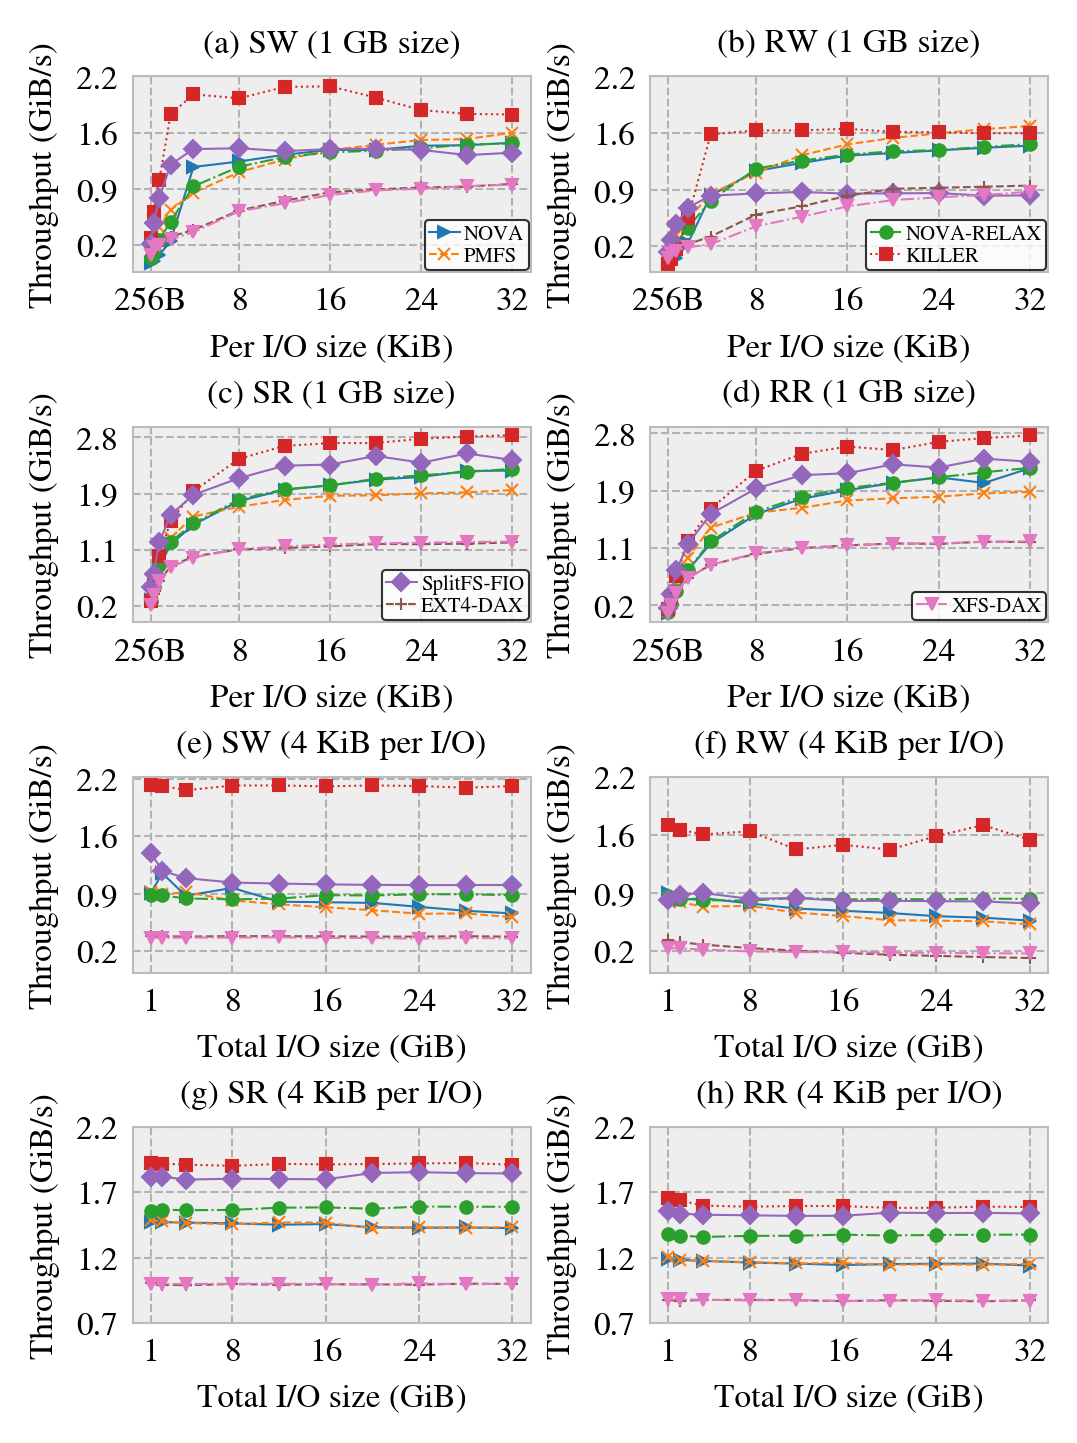

In [3]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('bmh')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("../FIG-ST-MICRO/performance-comparison-table-bsize", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(12)))

line_width = 0.5
# colors = ["#2b2d42", "#8d99ae", "#1a535c", "#ef233c", "#4ecdc4"]
marks = [">", "x", "o", "s", "D", "+", "v", "<", "d", "^", "p", "h", "H", "X", "*", "|", "_"]
# seven line types
line_types = ["-", "--", "-.", ":", "-", "--", "-."]
subtitles = ["(a) SW (1 GB size)", "(b) RW (1 GB size)", "(c) SR (1 GB size)", "(d) RR (1 GB size)"]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["seq-write", "rnd-write", "seq-read", "rnd-read"]
# bsize = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]
bsize =[256, 512, 1024, 2048, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768]

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.5 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(ylim0, ylim1)

# gs0 = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.6)
lines = []
cmap = "tab10"

for op_idx, op in enumerate(ops):
    subfig = plt.subplot(4, 2, op_idx + 1)
    for idx, fs in enumerate(fss):
        if fs == "PMM":
            continue
        line, = plt.plot(bsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), markerfacecolor=plt.get_cmap(cmap)(idx), linewidth=line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx])
        
        lines.append(line)
    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    selected_bsize = bsize
    plt.xticks([256, 8192, 16384, 24576, 32768], labels=[ "256B", 8, 16, 24, 32], fontsize=8)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    # subfig.text(0.5, -0.3, "Threads (#.)", ha='center', va='center', fontsize=6, transform=subfig.transAxes)
    plt.xlabel("Per I/O size (KiB)", fontsize=8) 
    plt.title(subtitles[op_idx], fontsize=8, loc='center')
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
    plt.ylabel('Throughput (GiB/s)', fontsize=8)
    # if (op_idx == 0 or op_idx == 2):
    if op_idx == 0 or op_idx == 1:
        plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)
    else:
        plt.yticks(np.linspace(0.25, 2.75, 4), fontsize=8)

steps = [2, 2, 2, 2]
for ax_id, ax in enumerate(fig.axes):
    start = sum(steps[:ax_id])
    end = start + steps[ax_id]

    leg = ax.legend(lines[start : end], fss[start : end], loc='lower right', bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes, ncol=1, fontsize=5, frameon=True, columnspacing=0.5, handletextpad=0.2, borderaxespad=0.1, handlelength=1.5, labelspacing=0.1, borderpad=0.2)
    
    frame = leg.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black')

fss.replace("SplitFS-FIO", "SplitFS", inplace=True)

# FSIZE .....................................................................
with open("../FIG-ST-MICRO/performance-comparison-table-fsize", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

df.drop(df[df['file_system'] == "PMM"].index, inplace=True)
# Plotting Settings

subtitles = ["(e) SW (4 KiB per I/O)", "(f) RW (4 KiB per I/O)", "(g) SR (4 KiB per I/O)", "(h) RR (4 KiB per I/O)"]
fss = df['file_system'].drop_duplicates().reset_index().drop(columns=['index'])['file_system']
ops = ["seq-write", "rnd-write", "seq-read", "rnd-read"]
fsize = [1024, 2048, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768]


for op_idx, op in enumerate(ops):
    subfig = plt.subplot(4, 2, op_idx + 1 + 4)
    # subfig = plt.subplot(gs0[op_idx])
    for idx, fs in enumerate(fss):
        if fs == "PMM":
            continue
        line, = plt.plot(fsize, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), markerfacecolor=plt.get_cmap(cmap)(idx), linewidth=line_width,label=fs, marker=marks[idx], markersize=3, markeredgewidth=0.5, linestyle=line_types[idx])
        
            
        # plt.scatter(num_jobs, df[(df['file_system'] == fs) & (df['ops'] == op)]['bandwidth(MiB/s)'] / 1024, color=plt.get_cmap(cmap)(idx), s=0.1)
        lines.append(line)
    ax = fig.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)
    plt.xticks([1024, 8192, 16384, 24576, 32768], labels=[1, 8, 16, 24, 32], fontsize=8)
    plt.tick_params(bottom=False, top=False, left=False, right=False)
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
    plt.xlabel("Total I/O size (GiB)", fontsize=8) 
    plt.title(subtitles[op_idx], fontsize=8, loc='center')
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=8)
    plt.ylabel('Throughput (GiB/s)', fontsize=8)
    # if (op_idx == 0 or op_idx == 2):
    if op_idx == 0 or op_idx == 1:
        plt.yticks(np.linspace(0.25, 2.25, 4), fontsize=8)
    else:
        plt.yticks(np.linspace(0.65, 2.25, 4), fontsize=8)
        plt.ylim(0.65, 2.25)

plt.tight_layout(pad=0.4)
# gs0.tight_layout(fig)
plt.savefig("./FIG-IO-VERTICAL.pdf", bbox_inches='tight', pad_inches=0)